(93, 512, 512)


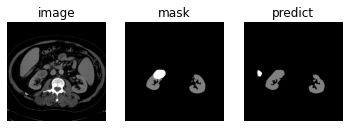

INFO: masks len:93
INFO: masks len:torch.Size([93, 512, 512])


In [22]:
"""
1. predict patient nodule
"""

import torch
from utils.config import Config
from utils.message import Msg
from utils.validation import Validation, get_cube, combine_image
from net.ResUnet import ResNetUNet
from utils.save import Save
from utils.convert import Convert
from utils.visualization import show_views
import segmentation_models_pytorch as smp
from net.baseNet import UNet_3d
from utils.crop import get_crop_info
from data.BasisDataset import BaseDataset
import numpy as np


msg = Msg()
config = Config()
validation = Validation()
convert_file = Convert()
save = Save()

# model = UNet(n_channels=1, classes=2)
config.first_model = f"./ResNetUNet_sec_False_all_Adam_0/CP_epoch1.pth"
# model = smp.Unet('resnet34', encoder_weights='imagenet', classes=2,in_channels=1)
model1 = ResNetUNet(in_channel=1, classes=4)
model1.load_state_dict(torch.load(config.first_model,
                                  map_location=config.device))
model1.to(device=config.device)

# raw image root
image_root = "/public/datasets/kidney/kits21/kits21/data/case_00270/imaging.nii.gz"
mask_root = "/public/datasets/kidney/kits21/kits21/data/case_00270/aggregated_MAJ_seg.nii.gz"
# xcd fix
patient_name = ""
images_numpy, spacing = convert_file.select(image_root)
ground_t,spacing = convert_file.select(mask_root)

# nodule segment
# masks = validation.predict_all(model, images_numpy, config)
print(images_numpy.shape)
#     images_numpy =np.expand_dims(images_numpy, axis=1)
first_masks = validation.predict_all(model1, BaseDataset.preprocess(images_numpy), config)
# save
show_views(images_numpy[39], ground_t[39], first_masks[39], cmap="gray")
msg.norm("masks len", len(first_masks))
msg.norm("masks len", first_masks.shape)

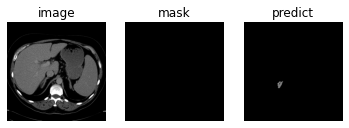

In [23]:
index = 20

show_views(images_numpy[index], ground_t[index], first_masks[index], cmap="gray")

In [25]:
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
print(validation.calculate_metrics(first_masks, ground_t,spacing))
print(first_masks.shape)


[[0.95261003 0.90228155]
 [0.26627889 0.1093806 ]
 [0.2789718  0.13072221]]
torch.Size([93, 512, 512])


In [34]:
save.save_2_nii(first_masks.float(), save_path=config.save_path,
                patient_name="kidney")

INFO: info:save nii


In [26]:
crop_info = get_crop_info(images_numpy,first_masks)
print(torch.from_numpy(images_numpy).shape, first_masks.shape)
print(crop_info)

torch.Size([93, 512, 512]) torch.Size([93, 512, 512])
[{'slice': 10, 'patch_count': 0, 'bbox': [95, 351, 241, 497]}, {'slice': 10, 'patch_count': 1, 'bbox': [106, 362, 234, 490]}, {'slice': 11, 'patch_count': 0, 'bbox': [129, 385, 253, 509]}, {'slice': 17, 'patch_count': 0, 'bbox': [239, 495, 192, 448]}, {'slice': 17, 'patch_count': 1, 'bbox': [249, 505, 203, 459]}, {'slice': 19, 'patch_count': 0, 'bbox': [198, 454, 58, 314]}, {'slice': 19, 'patch_count': 1, 'bbox': [206, 462, 52, 308]}, {'slice': 20, 'patch_count': 0, 'bbox': [195, 451, 59, 315]}, {'slice': 23, 'patch_count': 0, 'bbox': [203, 459, 28, 284]}, {'slice': 24, 'patch_count': 0, 'bbox': [203, 459, 28, 284]}, {'slice': 25, 'patch_count': 0, 'bbox': [201, 457, 27, 283]}, {'slice': 25, 'patch_count': 1, 'bbox': [228, 484, 222, 478]}, {'slice': 25, 'patch_count': 2, 'bbox': [136, 392, 112, 368]}, {'slice': 25, 'patch_count': 3, 'bbox': [139, 395, 114, 370]}, {'slice': 26, 'patch_count': 0, 'bbox': [199, 455, 25, 281]}, {'slice'

In [27]:
# --------------------------------------------------------- second network--------------------

crop_images, crop_masks = get_cube(torch.from_numpy(images_numpy).unsqueeze(dim=1),
                                   first_masks.unsqueeze(dim=1),crop_info)

print(crop_images.shape)
config.second_model = f"./ResNetUNet_sec_True_aug_Adam_0/CP_epoch16.pth"
model2 = ResNetUNet(in_channel=1, classes=4)
model2.load_state_dict(torch.load(config.first_model,
                                  map_location=config.device))
model2.to(device=config.device)
second_masks = validation.predict_all(model2, BaseDataset.preprocess(crop_images), config)


torch.Size([88, 1, 256, 256])


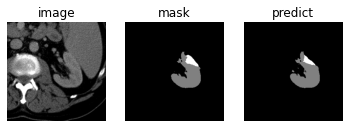

[93, 1, 512, 512]
(93, 1, 512, 512)


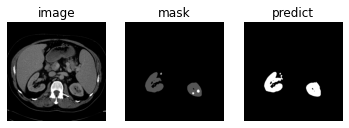

INFO: info:save nii


In [28]:
show_views(crop_images[39][0], crop_masks[39][0], second_masks[39], cmap="gray")
fina_masks = combine_image(second_masks, images_numpy.shape, crop_info)
fina_masks = fina_masks.squeeze()
index = 30
show_views(images_numpy[index], ground_t[index], fina_masks[index], cmap="gray")
save.save_2_nii(fina_masks, save_path=config.save_path,
                patient_name="kidney")


In [30]:
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
print(validation.calculate_metrics(fina_masks, ground_t,spacing))
print(fina_masks.shape)

[[0.95689246 0.91046064]
 [0.31523869 0.12089167]
 [0.27396131 0.11026893]]
torch.Size([93, 512, 512])
